Importing Packages And Basic Set up

In [2]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss

import numpy as np
import pandas as pd
from plotnine import *

Importing Datasets

In [3]:
# Importing maindata
file_path = "C://Users/soren/Downloads/"
x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Dataset

In [4]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int


# indicator for if treatment has occured in state i
basic_merged["year_indic"] = (basic_merged["year"] >= basic_merged["Year_Implemented"]) 


# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] # * basic_merged["year_indic"]
basic_merged.head()
basic_merged["State_Name"].values[0]

'AL'

$\underline{\bold{\text{Estimating causal effect}}}$

In [5]:
def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str, y1:int, y0:int):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''
    # Setting up prediction vectors
    predictions0_y1 = np.full_like(y, np.nan, dtype=float)
    predictions1_y1 = np.full_like(y, np.nan, dtype=float)
    predictions0_y0 = np.full_like(y, np.nan, dtype=float)
    predictions1_y0 = np.full_like(y, np.nan, dtype=float)

    # k-folding
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point
    X0_y1 = X_w_treatment.copy()
    X0_y1["A"] = 0
    X0_y1["year"] = y1

    X1_y1 = X_w_treatment.copy()
    X1_y1["A"] = 1
    X1_y1["year"] = y1

    X0_y0 = X_w_treatment.copy()
    X0_y0["A"] = 0
    X0_y0["year"] = y0

    X1_y0 = X_w_treatment.copy()
    X1_y0["A"] = 1
    X1_y0["year"] = y0

    year_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    treat_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model()
        q.fit(X_train, y_train)
        #print(q.score(X_w_treatment.loc[test_index], y.loc[test_index]))

        # This saves the vector of years so we only get the att for the 1997 group
        year_vec[test_index] =  X_w_treatment["year"].loc[test_index]

        # This saves the vector of treated statuses, as we want to condition on A = 1
        treat_vec[test_index] = A.loc[test_index]
        if output_type =='binary':
            predictions0_y1[test_index] = q.predict_proba(X0_y1.loc[test_index])[:, 1]
            predictions1_y1[test_index] = q.predict_proba(X1_y1.loc[test_index])[:, 1]
            predictions0_y0[test_index] = q.predict_proba(X0_y0.loc[test_index])[:, 1]
            predictions1_y0[test_index] = q.predict_proba(X1_y0.loc[test_index])[:, 1]
        elif output_type == 'continuous':
            predictions0_y1[test_index] = q.predict(X0_y1.loc[test_index])
            predictions1_y1[test_index] = q.predict(X1_y1.loc[test_index])
            predictions0_y0[test_index] = q.predict(X0_y0.loc[test_index])
            predictions1_y0[test_index] = q.predict(X1_y0.loc[test_index])

    assert np.isnan(predictions0_y1).sum() == 0
    assert np.isnan(predictions1_y1).sum() == 0
    assert np.isnan(predictions0_y0).sum() == 0
    assert np.isnan(predictions1_y0).sum() == 0
    return predictions1_y1, predictions1_y0, predictions0_y1, predictions0_y0, year_vec, treat_vec

In [6]:
# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]

In [13]:
def get_att(state_fips,confounder_list, treat_year, g_d_1, model_list, dataframe):
    '''
    state_fips: an integer corresponding to the fips number of the state being tested
    confounder_list: a list of the columns names 

    '''
                                                    
    results_df = {}

    state_level = dataframe[confounder_list + ["under19", "treatment", "pubonly", "insured", "privonly", "Year_Implemented","State_Name"]]
    state_level = state_level[state_level["stfips"] == state_fips]
    state_level = state_level.dropna(axis = 0)
    state_level["year"] = state_level["year"] - g_d_1 # Normalizing for interpretability. 
                                                # t = 1 is when treatment occurs first

    state_name = state_level["State_Name"].values[0]

    state_level = state_level.reset_index(drop=True)

    for i in range(1992, 2009):  # We compute the ATT for each year

        top_year = i - (treat_year - 1)  # Normalizing for interpretability (t = 1 is when treatment occurs)
        # For any year prior to treatment (like 1995), it says we should compare that year (t = t') to the prior year (t = t' - 1)
        if top_year >= 1:
            base_year = 0  # This is the year right before treatment (i.e. g_d_1 from above)
        else:
            base_year = top_year - 1

        for response in ["insured"]:
            for model in model_list:
                
                # Setting up 
                confounders = state_level[confounder_list]
                treatment = state_level['treatment']
                outcome = state_level[response]

                # Fitting
                term_1, term_2, term_3, term_4, year_vec, treat_vec = outcome_k_fold_fit_and_predict(model, \
                                                    X=confounders, y=outcome, A=treatment,  n_splits=5, \
                                                    output_type="binary", y1=top_year, y0=base_year)
                weight = (year_vec == 1) * (treat_vec == 1) # We only want the ATT, so we weight appropriately
                                                            # to only look at the untils treated at t=1
                weight = weight / np.mean(weight)
                final = weight * (term_1 - term_2 - (term_3 - term_4))

                # Multiplying by 100 to convert to %
                std = np.std(final) / np.sqrt(term_1.shape[0]) * 1.96 * 100  # the ".shape" part is just to get the right n
                mean = np.mean(final) * 100

                # Adding a value to each row for each desired column
                results_df.setdefault('year',[]).append(i)
                results_df.setdefault('att',[]).append(mean)
                results_df.setdefault('std',[]).append(std)
                results_df.setdefault('state',[]).append(state_fips)
                results_df.setdefault('state_name',[]).append(state_name)
                results_df.setdefault('model',[]).append(model.__name__ )
                results_df.setdefault('response',[]).append(response)
                results_df.setdefault('treat_year',[]).append(treat_year)

    results_df = pd.DataFrame(results_df)

    return results_df

# Estimating the att for one state

def forest():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(max_depth=10, n_estimators=1000)

models_to_use = [forest]
simple_att = get_att(16, list_of_confounders,1997,1996, models_to_use, basic_merged)
simple_att.head()

,year,att,std,state,state_name,model,response,treat_year
0,1992,-1.435706,0.473438,16,ID,forest,insured,1997
1,1993,-1.242578,0.311280,16,ID,forest,insured,1997
2,1994,0.745286,0.270941,16,ID,forest,insured,1997
3,1995,0.402632,0.173461,16,ID,forest,insured,1997
4,1996,0.476052,0.202720,16,ID,forest,insured,1997


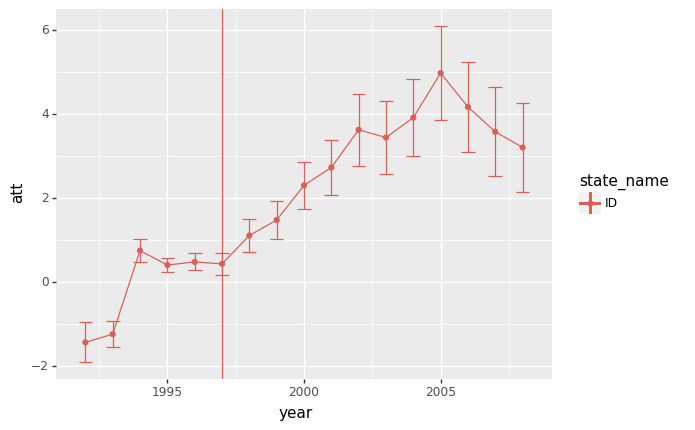

<ggplot: (110528469664)>

In [29]:
simple_att['att-error'] = simple_att['att'] - simple_att['std']
simple_att['att+error'] = simple_att['att'] + simple_att['std']
ggplot(simple_att, aes(x='year', y='att', color = 'state_name')) + \
geom_point() + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_line() + \
geom_vline(aes(xintercept = 'treat_year', color = "state_name"))


In [ ]:
# Testing which models perform best for Idaho
#models_to_use = [forest, boost, ]
#get_att(16, list_of_confounders,1997,1996, models_to_use, basic_merged)

In [27]:
# Evaluate the ATT's for all the states which implemented programs after 1997

# Get all years (other than never) that states implemented programs
law_years = np.sort(basic_merged['Year_Implemented'].unique())[:-1]

all_state_df = pd.DataFrame()

for year in law_years:
    # Get all states which implemented programs in that year
    states_in_year = basic_merged[basic_merged['Year_Implemented'] == year]["stfips"].unique()

    # Only do the analysis for the first state in each year (so the code runs within 5 min)
    for state in [states_in_year[0]]:

        new_state = get_att(int(state), list_of_confounders,year,year-1, models_to_use, basic_merged)
        
        all_state_df = pd.concat([all_state_df, new_state], ignore_index=True)

all_state_df.head()

,year,att,std,state,state_name,model,response,treat_year
0,1992,-1.098580,0.443762,9,CT,forest,insured,1997
1,1993,0.457006,0.463045,9,CT,forest,insured,1997
2,1994,0.831786,0.476206,9,CT,forest,insured,1997
3,1995,0.533048,0.334648,9,CT,forest,insured,1997
4,1996,0.373961,0.310168,9,CT,forest,insured,1997


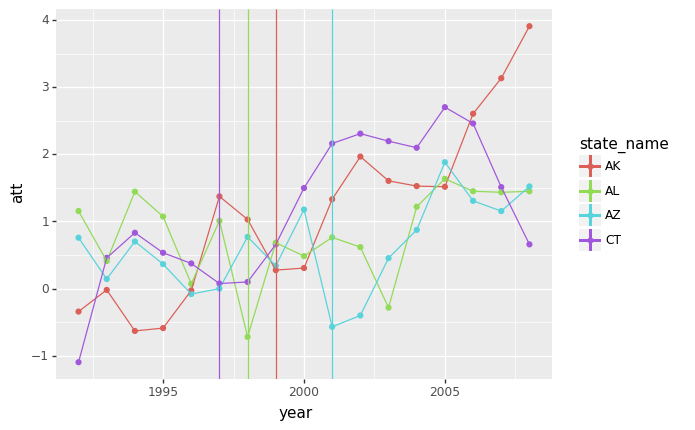

<ggplot: (110527852337)>

In [34]:
all_state_df['att-error'] = all_state_df['att'] - all_state_df['std']
all_state_df['att+error'] = all_state_df['att'] + all_state_df['std']
ggplot(all_state_df, aes(x='year', y='att', color = 'state_name', group='state_name')) + \
geom_point() + \
geom_line() + \
geom_vline(aes(xintercept = 'treat_year', color = "state_name"))
#geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \

In [15]:
# Checking parallel trends by doing the same analysis pretending that the treatment
# was performed 1 year after it actually was
law_years = np.sort(basic_merged['Year_Implemented'].unique())[:-1]

all_state_df = pd.DataFrame()

for year in law_years:
    
    states_in_year = basic_merged[basic_merged['Year_Implemented'] == year]["stfips"].unique()

    for state in [states_in_year[0]]:

        new_state = get_att(state, list_of_confounders,year+1,year, models_to_use, basic_merged)
        
        all_state_df = pd.concat([all_state_df, new_state], ignore_index=True)

all_state_df['att-error'] = all_state_df['att'] - all_state_df['std']
all_state_df['att+error'] = all_state_df['att'] + all_state_df['std']
ggplot(all_state_df, aes(x='year', y='att', color = 'state')) + \
geom_point() + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error'))

array([ 1.,  5.,  6.,  8., 11., 12., 17., 19., 21., 22., 24., 26., 27.,
       28., 29., 31., 32., 33., 34., 37., 38., 39., 46., 48., 49.])

In [ ]:
# Doing a placebo analysis to see if states which never implemented still show casual effect